In [3]:
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 13.4 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 16.1 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 15.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 30.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 25.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# ML-based Ticket Desirability Scoring Model using TensorFlow
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

In [5]:
# Connect to database and load all tickets
tables = ["tickets", "ticketsbsb", "ticketscon", "ticketsfb"]
conn = sqlite3.connect("tickets.db")
dfs = []
for table in tables:
    df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    df["sport_table"] = table
    dfs.append(df)
conn.close()

df_all = pd.concat(dfs, ignore_index=True)

# Drop rows with missing critical values
df_all = df_all.dropna(subset=["estimated_price", "section", "row", "date", "home_team", "away_team"])


In [6]:
# Feature engineering
def parse_section(section):
    try:
        sec = section.lower()
        if "floor" in sec:
            return 100
        if sec in ("ga", "general admission"):
            return 200
        return int(sec)
    except:
        return 300

def parse_row(row):
    row = str(row).strip().upper()
    if row.isdigit():
        return int(row)
    row = ''.join(filter(str.isalpha, row))
    if not row:
        return 50
    value = 0
    for c in row:
        value = value * 26 + (ord(c) - ord('A') + 1)
    return value

df_all["section_num"] = df_all["section"].apply(parse_section)
df_all["row_num"] = df_all["row"].apply(parse_row)
df_all["estimated_price"] = df_all["estimated_price"].astype(float)

# Normalize scores within each event
df_all["event_id"] = df_all["date"] + "_" + df_all["home_team"] + "_" + df_all["away_team"]
df_all["rank_within_event"] = df_all.groupby("event_id")["estimated_price"].rank(pct=True)
df_all["score_10"] = (1 - df_all["rank_within_event"]) * 10


In [7]:
# Prepare features
cat_features = ["section_num", "row_num"]
num_features = ["estimated_price"]

data = df_all[cat_features + num_features + ["score_10"]].copy()

# Label encoding
encoders = {}
for col in cat_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le

# Normalize numerical features
scaler = MinMaxScaler()
data[num_features] = scaler.fit_transform(data[num_features])


In [8]:
# Train/test split
X = data[cat_features + num_features]
y = data["score_10"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build TensorFlow model
inputs = []
embeddings = []

for col in cat_features:
    vocab_size = data[col].nunique()
    input_layer = Input(shape=(1,), name=col)
    embed = Embedding(input_dim=vocab_size + 1, output_dim=4)(input_layer)
    embed = Flatten()(embed)
    inputs.append(input_layer)
    embeddings.append(embed)

num_input = Input(shape=(len(num_features),), name="num_input")
inputs.append(num_input)

In [ ]:
x = Concatenate()(embeddings + [num_input])
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Prepare model inputs
train_inputs = {col: np.array(X_train[col]) for col in cat_features}
train_inputs["num_input"] = np.array(X_train[num_features])
val_inputs = {col: np.array(X_val[col]) for col in cat_features}
val_inputs["num_input"] = np.array(X_val[num_features])

# Train model
model.fit(train_inputs, y_train / 10.0, validation_data=(val_inputs, y_val / 10.0), epochs=50, batch_size=128)

# Save model and preprocessors
model.save("ticket_score_model_tf.keras")
joblib.dump(encoders, "encoders.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model training complete. Saved as 'ticket_score_model_tf' with encoders and scaler.")


Epoch 1/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0490 - val_loss: 0.0263
Epoch 2/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0271 - val_loss: 0.0220
Epoch 3/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0231 - val_loss: 0.0203
Epoch 4/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0213 - val_loss: 0.0177
Epoch 5/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0193 - val_loss: 0.0166
Epoch 6/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0180 - val_loss: 0.0158
Epoch 7/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0177 - val_loss: 0.0157
Epoch 8/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0174 - val_loss: 0.0154
Epoch 9/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0170 - val_loss: 0.0154
Epoch 10/10
622/622 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0172 - val_loss: 0.0150
Model training complete. Saved as 'ticket_score_model_tf' with encoders and scaler.


In [10]:
# --- Score all listings using the trained model ---
all_inputs = {col: np.array(data[col]) for col in cat_features}
all_inputs["num_input"] = np.array(data[num_features])

predictions = model.predict(all_inputs)
df_all["predicted_score_10"] = (predictions.flatten() * 10).round(1)

# Trim unnecessary columns for output
output_cols = [
    "id", "date", "home_team", "away_team", "section", "row",
    "price", "estimated_price", "url", "source", "created_at", "predicted_score_10"
]
df_all[output_cols].to_csv("scored_tickets.csv", index=False)
print("All ticket listings scored and saved to scored_tickets.csv")


3109/3109 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
All ticket listings scored and saved to scored_tickets.csv


Score distribution chart saved as 'score_distribution_chart.png'


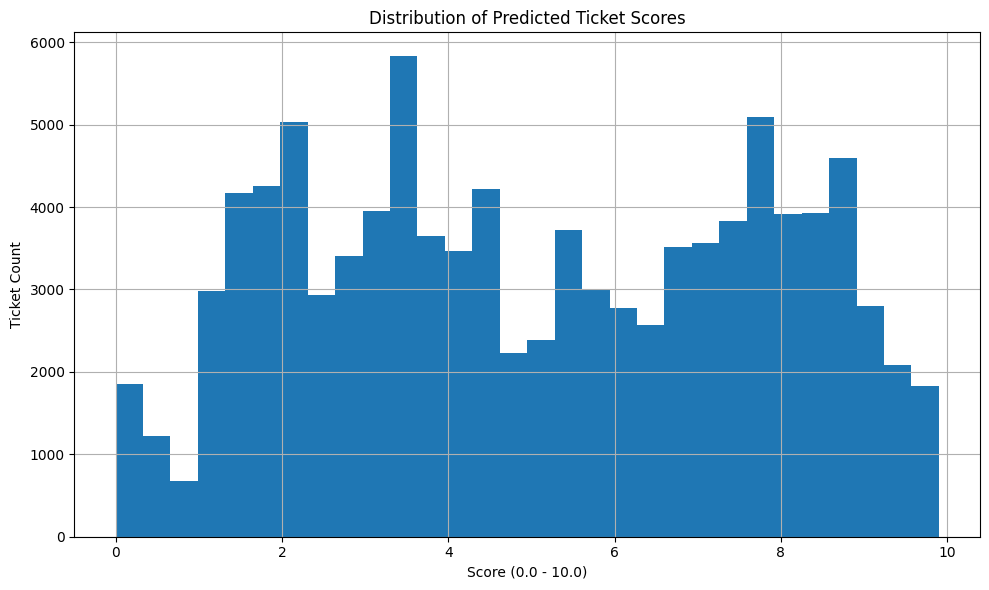

In [11]:
# Visualization
plt.figure(figsize=(10, 6))
df_all["predicted_score_10"].hist(bins=30)
plt.title("Distribution of Predicted Ticket Scores")
plt.xlabel("Score (0.0 - 10.0)")
plt.ylabel("Ticket Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("score_distribution_chart.png")
print("Score distribution chart saved as 'score_distribution_chart.png'")
